In [1]:
import fastfusion as ff
from math import log10

ff.set_n_parallel_jobs(32)

def get_runs(
    arch: str,
    workload: str,
    jinja_parse_data: dict,
):
    spec = ff.Specification.from_yaml(arch, workload, jinja_parse_data=jinja_parse_data)
    spec.arch["ArrayDummy"].constraints.spatial["reuse_input"].min_utilization = 0
    spec.arch["ArrayDummy"].constraints.spatial["reuse_output"].min_utilization = 0
    spec.arch["MainMemory"].constraints.tensors.keep = "All"
    spec.arch["GlobalBuffer"].constraints.tensors.keep = "output | input | ~MainMemory"
    spec.arch["GlobalBuffer"].constraints.tensors.may_keep = "weight | ~MainMemory"
    if "tpu_v4i" in arch:
        # spec.arch["LocalBuffer"].constraints.spatial.append(ff.constraints.Spatial(name="Z", min_utilization=1))
        spec.arch["LocalBuffer"].constraints.tensors.keep = "input | output"

    spec.mapper.ffm.metrics = ff.Metrics.ENERGY | ff.Metrics.LATENCY

    print(spec.workload.shape)

    def run_mapper(spec: ff.Specification, count_option: str):
        spec.mapper.ffm._count_option_for_mapsapce_size_evaluation = count_option
        return ff.mapper.FFM.make_pmappings(spec, cache_dir="/tmp/ff_cache")

    normal = run_mapper(spec, ())
    total = run_mapper(spec, ("redundant_dataplacements", "non_helpful_loops_for_loop_orders", "non_helpful_tile_shapes", "redundant_loop_orders"))
    no_redundant_dataplacements = run_mapper(spec, ("non_helpful_loops_for_loop_orders", "non_helpful_tile_shapes", "redundant_loop_orders"))
    no_non_helpful_tile_shapes = run_mapper(spec, ("non_helpful_loops_for_loop_orders", "redundant_loop_orders"))
    no_non_helpful_loops_for_loop_orders = run_mapper(spec, ("redundant_loop_orders"))
    return (
        spec,
        normal,
        total,
        no_redundant_dataplacements,
        no_non_helpful_tile_shapes,
        no_non_helpful_loops_for_loop_orders,
    )

def get_reduction_per_piece(
    spec: ff.Specification,
    normal: ff.mapper.FFM.MultiEinsumPmappings,
    total: ff.mapper.FFM.MultiEinsumPmappings,
    no_redundant_dataplacements: ff.mapper.FFM.MultiEinsumPmappings,
    no_non_helpful_tile_shapes: ff.mapper.FFM.MultiEinsumPmappings,
    no_non_helpful_loops_for_loop_orders: ff.mapper.FFM.MultiEinsumPmappings,
):
    def _count(f):
        r = f(per_einsum=True)
        # r['Total'] = f()
        return r

    n_total = _count(total.n_total_pmappings)
    n_no_redundant_dataplacements = _count(no_redundant_dataplacements.n_total_pmappings)
    n_no_non_helpful_tile_shapes = _count(no_non_helpful_tile_shapes.n_total_pmappings)
    n_no_non_helpful_permutations = _count(normal.n_total_pmappings)
    n_ffm_evaluated = _count(normal.n_evaluated_pmappings)

    prev = [n_total]
    def get_reduction(to_mapspace, from_mapspace=None):
        if from_mapspace is None:
            from_mapspace = prev.pop(0)
            prev.append(to_mapspace)
        return {k: log10(max(v / to_mapspace[k], 1)) for k, v in from_mapspace.items()}

    redundant_dataplacements_reduction = get_reduction(n_no_redundant_dataplacements)
    non_helpful_tile_shapes_reduction = get_reduction(n_no_non_helpful_tile_shapes)
    redundant_loop_orders_reduction = get_reduction(n_no_non_helpful_permutations)
    pruned_tile_shapes_reduction = get_reduction(n_ffm_evaluated)
    remaining = get_reduction({k: 1 for k in n_total.keys()})

    print(redundant_dataplacements_reduction)
    print(non_helpful_tile_shapes_reduction)
    print(redundant_loop_orders_reduction)
    print(pruned_tile_shapes_reduction)

    non_helpful_tile_shapes_reduction = {
        k: v + redundant_dataplacements_reduction[k] for k, v in non_helpful_tile_shapes_reduction.items()
    }
    redundant_dataplacements_reduction = {
        k: 0 for k in n_total.keys()
    }

    einsums = [e.name for e in spec.workload.einsums if len(e.tensor_accesses) > 2]# + ["Total"]
    einsums = [e for e in einsums if e in remaining]

    return {
        e: {
            # "Dominated Dataplacements": redundant_dataplacements_reduction[e],
            "Loop Pruning": non_helpful_tile_shapes_reduction[e],
            "Dataflow Pruning": redundant_loop_orders_reduction[e],
            "Partial Tile Shape Pruning": pruned_tile_shapes_reduction[e],
        } for e in einsums
    }, total.n_total_pmappings(per_einsum=True), normal.n_evaluated_pmappings(per_einsum=True)


In [2]:
import matplotlib.pyplot as plt
from format_plot import format_plot

def make_stacked_bar_chart(
    results: dict[str, dict[str, float]],
    ax: plt.Axes
):
    categories = list(next(iter(results.values())).keys())
    labels = list(results.keys())
    data = list(zip(*results.values()))
    bottom = [0] * len(labels)
    for i, cat in enumerate(categories):
        ax.bar(labels, [results[l][cat] for l in labels], label=cat, bottom=bottom)
        bottom = [b + v for b, v in zip(bottom, [results[l][cat] for l in labels])]
    format_plot(ax)
    # Set the Y axis label to be 10^x
    ax.set_yticklabels([f"$10^{{{int(y)}}}$" for y in ax.get_yticks()])
    ax.set_xticklabels(labels, rotation=45, ha="right")


reductions_gpt, totals_gpt, evaluated_gpt = get_reduction_per_piece(*get_runs(
    "../../examples/arches/tpu_v4i_like.arch.yaml",
    "../../examples/workloads/gpt3_6.7B.workload.yaml",
    dict(BATCH_SIZE=64, N_TOKENS=65536),
))

# reductions_gpt_b1 = get_reduction_per_piece(*get_runs(
#     "../../examples/arches/tpu_v4i_like.arch.yaml",
#     "../../examples/workloads/gpt3_6.7B.workload.yaml",
#     dict(BATCH_SIZE=1, N_TOKENS=65536),
# ))

ff.set_n_parallel_jobs(32)
reductions_mobilenet, totals_mobilenet, evaluated_mobilenet = get_reduction_per_piece(*get_runs(
    "../../examples/arches/nvdla_like.arch.yaml",
    "../../examples/workloads/mobilenet_28.workload.yaml",
    dict(BATCH_SIZE=64),
))

# reductions_mobilenet_b1 = get_reduction_per_piece(*get_runs(
#     "../../examples/arches/nvdla_like.arch.yaml",
#     "../../examples/workloads/mobilenet_28.workload.yaml",
#     dict(BATCH_SIZE=1),
# ))

# fig, ax = plt.subplots(figsize=(20, 10))
# make_stacked_bar_chart(reductions_gpt, ax)
# ax.set_title(f"TPU-like, GPT-3 6.7B")
# ax.set_ylabel(f"Reduction in #Mappings")
# plt.show()

# fig, ax = plt.subplots(figsize=(20, 10))
# make_stacked_bar_chart(reductions_mobilenet, ax)
# ax.set_title(f"NVDLA-like, MobileNet-v3")
# ax.set_ylabel(f"Reduction in #Mappings")
# plt.show()


WARNING Loading configuration file from /home/tanner/.config/fastfusion/config.yaml


{'b': '0 <= b < 64', 'm': '0 <= m < 65536', 'p': '0 <= p < 65536', 'h': '0 <= h < 32', 'e': '0 <= e < 128', 'f': '0 <= f < 128', 'd': '0 <= d < 4096', 'c': '0 <= c < 16384', 'j': '0 <= j < 4096', 'g': '0 <= g < 4096'}
________________________________________________________________________________
[Memory] Calling fastfusion.mapper.FFM.main.make_pmappings.<locals>._make_pmappings_cached...
_make_pmappings_cached(spec=Specification(type=None, arch=Arch(type=None, nodes=ArchNodes([Memory(type=None, name='MainMemory', attributes=MemoryAttributes(type=None, n_instances=1, energy_scale=1, area_scale=1, energy=None, area=0, leak_power=0, leak_power_scale=1, latency='(read_actions + write_actions) / (8 * 614e9)', datawidth={'All()': 8}, size='inf'), spatial=[], constraints=ConstraintGroup(type=None, name=None, misc=Misc(type=None, enabled=True), spatial=[], temporal=Temporal(type=None, version='0.5', reuse='All', loop_bounds=[], rmw_first_update=[]), tensors=Tensors(type=None, keep='All', may

Generating pmapping templates for compute MAC Einsum I: 0it [00:00, ?it/s] ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum I: 1it [00:00,  8.28it/s]it/s]
Generating pmapping templates for compute ScalarUnit Einsum Q: 0it [00:00, ?it/s]s]
Generating pmapping templates for compute ScalarUnit Einsum V: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum K: 0it [00:00, ?it/s]s]
Generating pmapping templates for compute ScalarUnit Einsum AV: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum FFB: 0it [00:00, ?it/s]
Generating pmapping templates for compute MAC Einsum QK_softmax: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum QK: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum FFA: 0it [00:00, ?it/s] 18.26it/s]
Generating pmapping templates for compute ScalarUnit Einsum Z: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum QK_sof

__________________________________________make_pmappings_cached - 123.3s, 2.1min
Q: 9.05e12 total, 4.12e12 (1/2) valid, 9.48e06 (1/9.54e05) evaluated, 1 (1/9.05e12) Pareto-Optimal
V: 9.05e12 total, 4.12e12 (1/2) valid, 9.48e06 (1/9.55e05) evaluated, 1 (1/9.05e12) Pareto-Optimal
Z: 9.05e12 total, 4.01e12 (1/2) valid, 9.63e06 (1/9.39e05) evaluated, 1 (1/9.05e12) Pareto-Optimal
K: 9.05e12 total, 5.61e12 (1/2) valid, 1.47e07 (1/6.16e05) evaluated, 1 (1/9.05e12) Pareto-Optimal
QK: 1.53e11 total, 5.59e09 (1/27) valid, 1.97e06 (1/7.77e04) evaluated, 2 (1/7.66e10) Pareto-Optimal
AV: 1.53e11 total, 5.09e09 (1/30) valid, 2.24e06 (1/6.85e04) evaluated, 1 (1/1.53e11) Pareto-Optimal
FFA: 7.65e11 total, 1.60e11 (1/5) valid, 1.07e07 (1/7.13e04) evaluated, 1 (1/7.65e11) Pareto-Optimal
FFB: 7.65e11 total, 1.61e11 (1/5) valid, 1.11e07 (1/6.90e04) evaluated, 1 (1/7.65e11) Pareto-Optimal
QK_softmax: 4.86e04 total, 60 (1/809) valid, 136 (1/357) evaluated, 1 (1/4.86e04) Pareto-Optimal
I: 1.55e03 total, 10 (

Generating pmapping templates for compute MAC Einsum I: 0it [00:00, ?it/s], ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum I: 1it [00:00, 22.15it/s]
Generating pmapping templates for compute ScalarUnit Einsum V: 0it [00:00, ?it/s]s] ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum Q: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum QK: 0it [00:00, ?it/s]]
Generating pmapping templates for compute MAC Einsum QK_softmax: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum Z: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum FFA: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum FFB: 0it [00:00, ?it/s] 17.20it/s]
Generating pmapping templates for compute ScalarUnit Einsum QK_softmax: 4it [00:00, 28.06it/s]
Generating pmapping templates for compute ScalarUnit Einsum K: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit

___________________________________________make_pmappings_cached - 25.0s, 0.4min
K: 1.26e36 total, 8.05e16 (1/1.56e19) valid, 0 (1/inf) evaluated, 1 (1/1.26e36) Pareto-Optimal
V: 1.26e36 total, 8.05e16 (1/1.56e19) valid, 0 (1/inf) evaluated, 1 (1/1.26e36) Pareto-Optimal
Q: 1.26e36 total, 8.05e16 (1/1.56e19) valid, 0 (1/inf) evaluated, 1 (1/1.26e36) Pareto-Optimal
Z: 1.26e36 total, 8.05e16 (1/1.56e19) valid, 0 (1/inf) evaluated, 1 (1/1.26e36) Pareto-Optimal
QK: 4.52e36 total, 4.99e13 (1/9.07e22) valid, 0 (1/inf) evaluated, 1 (1/4.52e36) Pareto-Optimal
AV: 4.52e36 total, 4.99e13 (1/9.07e22) valid, 0 (1/inf) evaluated, 1 (1/4.52e36) Pareto-Optimal
FFA: 6.22e29 total, 1.12e15 (1/5.55e14) valid, 0 (1/inf) evaluated, 1 (1/6.22e29) Pareto-Optimal
FFB: 6.22e29 total, 1.12e15 (1/5.55e14) valid, 0 (1/inf) evaluated, 1 (1/6.22e29) Pareto-Optimal
QK_softmax: 1.17e06 total, 4.86e04 (1/24) valid, 0 (1/inf) evaluated, 1 (1/1.17e06) Pareto-Optimal
I: 9.28e03 total, 1.55e03 (1/6) valid, 0 (1/inf) evalu

Generating pmapping templates for compute MAC Einsum I: 0it [00:00, ?it/s]] ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum I: 1it [00:00, 18.22it/s]it/s]
Generating pmapping templates for compute ScalarUnit Einsum V: 0it [00:00, ?it/s]]
Generating pmapping templates for compute ScalarUnit Einsum K: 0it [00:00, ?it/s]s]
Generating pmapping templates for compute ScalarUnit Einsum Q: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum QK: 0it [00:00, ?it/s]]
Generating pmapping templates for compute ScalarUnit Einsum AV: 0it [00:00, ?it/s]
Generating pmapping templates for compute MAC Einsum QK_softmax: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum FFA: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum FFB: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum QK_softmax: 4it [00:00, 39.30it/s]
Generating pmapping templates for compute ScalarUnit Einsum Z: 

___________________________________________make_pmappings_cached - 26.9s, 0.4min
Q: 1.26e36 total, 8.05e16 (1/1.56e19) valid, 0 (1/inf) evaluated, 1 (1/1.26e36) Pareto-Optimal
V: 1.26e36 total, 8.05e16 (1/1.56e19) valid, 0 (1/inf) evaluated, 1 (1/1.26e36) Pareto-Optimal
K: 1.26e36 total, 8.05e16 (1/1.56e19) valid, 0 (1/inf) evaluated, 1 (1/1.26e36) Pareto-Optimal
Z: 1.26e36 total, 8.05e16 (1/1.56e19) valid, 0 (1/inf) evaluated, 1 (1/1.26e36) Pareto-Optimal
QK: 4.52e36 total, 4.99e13 (1/9.07e22) valid, 0 (1/inf) evaluated, 1 (1/4.52e36) Pareto-Optimal
AV: 4.52e36 total, 4.99e13 (1/9.07e22) valid, 0 (1/inf) evaluated, 1 (1/4.52e36) Pareto-Optimal
FFA: 6.22e29 total, 1.12e15 (1/5.55e14) valid, 0 (1/inf) evaluated, 1 (1/6.22e29) Pareto-Optimal
FFB: 6.22e29 total, 1.12e15 (1/5.55e14) valid, 0 (1/inf) evaluated, 1 (1/6.22e29) Pareto-Optimal
QK_softmax: 1.17e06 total, 4.86e04 (1/24) valid, 0 (1/inf) evaluated, 1 (1/1.17e06) Pareto-Optimal
I: 9.28e03 total, 1.55e03 (1/6) valid, 0 (1/inf) evalu

Generating pmapping templates for compute ScalarUnit Einsum I: 1it [00:00, 21.34it/s]
Generating pmapping templates for compute MAC Einsum I: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum V: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum K: 0it [00:00, ?it/s]s] ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum Q: 0it [00:00, ?it/s]]
Generating pmapping templates for compute MAC Einsum QK_softmax: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum QK: 0it [00:00, ?it/s]]
Generating pmapping templates for compute ScalarUnit Einsum Z: 0it [00:00, ?it/s]s]
Generating pmapping templates for compute ScalarUnit Einsum AV: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum FFA: 0it [00:00, ?it/s]
Generating pmapping templates for compute MAC Einsum QK: 4it [00:00, 35.76it/s]t/s]
Generating pmapping templates for compute ScalarUnit Einsum QK_softmax: 4it [00:

___________________________________________make_pmappings_cached - 25.1s, 0.4min
Z: 2.96e27 total, 8.05e16 (1/3.68e10) valid, 0 (1/inf) evaluated, 1 (1/2.96e27) Pareto-Optimal
Q: 2.96e27 total, 8.05e16 (1/3.68e10) valid, 0 (1/inf) evaluated, 1 (1/2.96e27) Pareto-Optimal
K: 2.96e27 total, 8.05e16 (1/3.68e10) valid, 0 (1/inf) evaluated, 1 (1/2.96e27) Pareto-Optimal
V: 2.96e27 total, 8.05e16 (1/3.68e10) valid, 0 (1/inf) evaluated, 1 (1/2.96e27) Pareto-Optimal
QK: 4.69e25 total, 4.99e13 (1/9.40e11) valid, 0 (1/inf) evaluated, 1 (1/4.69e25) Pareto-Optimal
FFA: 3.18e21 total, 1.12e15 (1/2.83e06) valid, 0 (1/inf) evaluated, 1 (1/3.18e21) Pareto-Optimal
AV: 4.69e25 total, 4.99e13 (1/9.40e11) valid, 0 (1/inf) evaluated, 1 (1/4.69e25) Pareto-Optimal
FFB: 3.18e21 total, 1.12e15 (1/2.83e06) valid, 0 (1/inf) evaluated, 1 (1/3.18e21) Pareto-Optimal
QK_softmax: 1.17e06 total, 4.86e04 (1/24) valid, 0 (1/inf) evaluated, 1 (1/1.17e06) Pareto-Optimal
I: 9.28e03 total, 1.55e03 (1/6) valid, 0 (1/inf) evalu

Generating pmapping templates for compute MAC Einsum I: 0it [00:00, ?it/s], ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum I: 1it [00:00, 19.43it/s]it/s]
Generating pmapping templates for compute ScalarUnit Einsum V: 0it [00:00, ?it/s]s]
Generating pmapping templates for compute ScalarUnit Einsum K: 0it [00:00, ?it/s]]
Generating pmapping templates for compute ScalarUnit Einsum QK: 0it [00:00, ?it/s]
Generating pmapping templates for compute MAC Einsum QK_softmax: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum AV: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum FFA: 0it [00:00, ?it/s] 25.53it/s]
Generating pmapping templates for compute ScalarUnit Einsum QK_softmax: 4it [00:00, 30.77it/s]
Generating pmapping templates for compute ScalarUnit Einsum Q: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum Z: 0it [00:00, ?it/s]s]
Generating pmapping templates for compute ScalarUnit 

___________________________________________make_pmappings_cached - 25.6s, 0.4min
K: 2.22e15 total, 8.05e16 (1/0) valid, 0 (1/inf) evaluated, 1 (1/2.22e15) Pareto-Optimal
V: 2.22e15 total, 8.05e16 (1/0) valid, 0 (1/inf) evaluated, 1 (1/2.22e15) Pareto-Optimal
Q: 2.22e15 total, 8.05e16 (1/0) valid, 0 (1/inf) evaluated, 1 (1/2.22e15) Pareto-Optimal
Z: 2.22e15 total, 8.05e16 (1/0) valid, 0 (1/inf) evaluated, 1 (1/2.22e15) Pareto-Optimal
QK: 3.67e12 total, 4.99e13 (1/0) valid, 0 (1/inf) evaluated, 1 (1/3.67e12) Pareto-Optimal
FFB: 1.73e13 total, 1.12e15 (1/0) valid, 0 (1/inf) evaluated, 1 (1/1.73e13) Pareto-Optimal
AV: 3.67e12 total, 4.99e13 (1/0) valid, 0 (1/inf) evaluated, 1 (1/3.67e12) Pareto-Optimal
FFA: 1.73e13 total, 1.12e15 (1/0) valid, 0 (1/inf) evaluated, 1 (1/1.73e13) Pareto-Optimal
QK_softmax: 1.17e06 total, 4.86e04 (1/24) valid, 0 (1/inf) evaluated, 1 (1/1.17e06) Pareto-Optimal
I: 9.28e03 total, 1.55e03 (1/6) valid, 0 (1/inf) evaluated, 1 (1/9.28e03) Pareto-Optimal
Total: 8.94e1

WARNING Loading configuration file from /home/tanner/.config/fastfusion/config.yaml


{'b': '0 <= b < 64', 'p0': '0 <= p0 < 28', 'q0': '0 <= q0 < 28', 'n0': '0 <= n0 < 24', 't0': '0 <= t0 < 192', 'n1': '0 <= n1 < 24', 'p1': '0 <= p1 < 28', 'q1': '0 <= q1 < 28', 'p2': '0 <= p2 < 28', 'q2': '0 <= q2 < 28', 't1': '0 <= t1 < 192', 'n2': '0 <= n2 < 24'}
________________________________________________________________________________
[Memory] Calling fastfusion.mapper.FFM.main.make_pmappings.<locals>._make_pmappings_cached...
_make_pmappings_cached(spec=Specification(type=None, arch=Arch(type=None, nodes=ArchNodes([Memory(type=None, name='MainMemory', attributes=MemoryAttributes(type=None, n_instances=1, energy_scale=1, area_scale=1, energy=None, area=None, leak_power=0, leak_power_scale=1, latency='(read_actions + write_actions) / (8 * 38.4e9)', datawidth={'All()': 8}, size='inf'), spatial=[], constraints=ConstraintGroup(type=None, name=None, misc=Misc(type=None, enabled=True), spatial=[], temporal=Temporal(type=None, version='0.5', reuse='All', loop_bounds=[], rmw_first_upd

Generating pmapping templates for compute MAC Einsum PiecewiseA0: 6it [00:00, 69.16it/s]
Generating pmapping templates for compute MAC Einsum PiecewiseB0: 6it [00:00, 67.66it/s]
Generating pmapping templates for compute MAC Einsum PiecewiseB2: 6it [00:00, 65.04it/s]
Generating pmapping templates for compute MAC Einsum PiecewiseA1: 6it [00:00, 34.96it/s]]
Generating pmapping templates for compute MAC Einsum Depthwise0: 24it [00:00, 138.55it/s]
Generating pmapping templates for compute MAC Einsum Depthwise1: 24it [00:00, 136.39it/s]
Generating jobs: 100%|██████████| 6/6 [00:00<00:00, 18.70it/s]
WARNING Einsum PiecewiseA0 has 6 pmapping templates:
WARNING 	[WA0,TA0,T0 in MainMemory] T-b,n0,p0,q0  [T0 in GlobalBuffer] T-t0  [TA0 in GlobalBuffer] T-n0  S-reuse_output-n0  S-reuse_input-t0  [WA0 in Register] T-b,p0,q0  MAC computes PiecewiseA0
WARNING 	[WA0,TA0,T0 in MainMemory] T-b,p0,q0,t0  [TA0 in GlobalBuffer] T-n0  [T0 in GlobalBuffer] T-t0  S-reuse_output-n0  S-reuse_input-t0  [WA0 in R

___________________________________________make_pmappings_cached - 17.3s, 0.3min
Depthwise0: 7.46e06 total, 1.83e07 (1/0) valid, 4.89e04 (1/153) evaluated, 2 (1/3.73e06) Pareto-Optimal
Depthwise1: 7.46e06 total, 1.74e07 (1/0) valid, 4.74e04 (1/158) evaluated, 2 (1/3.73e06) Pareto-Optimal
PiecewiseB0: 1.15e07 total, 1.65e07 (1/1) valid, 2.97e04 (1/386) evaluated, 2 (1/5.73e06) Pareto-Optimal
PiecewiseA0: 1.15e07 total, 1.26e07 (1/1) valid, 2.62e04 (1/438) evaluated, 2 (1/5.73e06) Pareto-Optimal
PiecewiseA1: 1.15e07 total, 1.26e07 (1/1) valid, 2.62e04 (1/438) evaluated, 2 (1/5.73e06) Pareto-Optimal
PiecewiseB2: 1.15e07 total, 1.65e07 (1/1) valid, 2.97e04 (1/386) evaluated, 2 (1/5.73e06) Pareto-Optimal
Total: 6.07e07 total, 9.38e07 (1/1) valid, 2.08e05 (1/292) evaluated, 12 (1/5.06e06) Pareto-Optimal
________________________________________________________________________________
[Memory] Calling fastfusion.mapper.FFM.main.make_pmappings.<locals>._make_pmappings_cached...
_make_pmappings_

Generating pmapping templates for compute MAC Einsum PiecewiseA1: 8it [00:00, 62.21it/s]
Generating pmapping templates for compute MAC Einsum PiecewiseB0: 8it [00:00, 64.70it/s]
Generating pmapping templates for compute MAC Einsum PiecewiseB2: 8it [00:00, 69.78it/s]
Generating pmapping templates for compute MAC Einsum PiecewiseA0: 8it [00:00, 58.83it/s]
Generating pmapping templates for compute MAC Einsum Depthwise0: 32it [00:00, 125.09it/s]
Generating pmapping templates for compute MAC Einsum Depthwise1: 32it [00:00, 82.71it/s]
Generating jobs: 100%|██████████| 6/6 [00:00<00:00,  6.56it/s]
WARNING Einsum PiecewiseA0 has 8 pmapping templates:
WARNING 	[WA0,TA0,T0 in MainMemory] T-b,n0,p0,q0  [T0 in GlobalBuffer] T-t0  [TA0 in GlobalBuffer] T-n0  S-reuse_output-n0  S-reuse_input-t0  [WA0 in Register] T-b,p0,q0  MAC computes PiecewiseA0
WARNING 	[WA0,TA0,T0 in MainMemory] T-b,p0,q0,t0  [TA0 in GlobalBuffer] T-n0  [T0 in GlobalBuffer] T-t0  S-reuse_output-n0  S-reuse_input-t0  [WA0 in Reg

___________________________________________make_pmappings_cached - 14.2s, 0.2min
Depthwise0: 6.94e29 total, 1.43e09 (1/4.86e20) valid, 0 (1/inf) evaluated, 2 (1/3.47e29) Pareto-Optimal
Depthwise1: 6.94e29 total, 1.43e09 (1/4.86e20) valid, 0 (1/inf) evaluated, 2 (1/3.47e29) Pareto-Optimal
PiecewiseA0: 1.10e23 total, 1.64e08 (1/6.68e14) valid, 0 (1/inf) evaluated, 1 (1/1.10e23) Pareto-Optimal
PiecewiseB2: 1.10e23 total, 1.64e08 (1/6.68e14) valid, 0 (1/inf) evaluated, 1 (1/1.10e23) Pareto-Optimal
PiecewiseA1: 1.10e23 total, 1.64e08 (1/6.68e14) valid, 0 (1/inf) evaluated, 1 (1/1.10e23) Pareto-Optimal
PiecewiseB0: 1.10e23 total, 1.64e08 (1/6.68e14) valid, 0 (1/inf) evaluated, 1 (1/1.10e23) Pareto-Optimal
Total: 1.39e30 total, 3.51e09 (1/3.95e20) valid, 0 (1/inf) evaluated, 8 (1/1.73e29) Pareto-Optimal
________________________________________________________________________________
[Memory] Calling fastfusion.mapper.FFM.main.make_pmappings.<locals>._make_pmappings_cached...
_make_pmappings_c

Generating pmapping templates for compute MAC Einsum PiecewiseA0: 6it [00:00, 69.66it/s]
Generating pmapping templates for compute MAC Einsum PiecewiseB0: 6it [00:00, 73.08it/s]
Generating pmapping templates for compute MAC Einsum PiecewiseA1: 6it [00:00, 67.35it/s]
Generating pmapping templates for compute MAC Einsum PiecewiseB2: 6it [00:00, 69.63it/s]
Generating pmapping templates for compute MAC Einsum Depthwise0: 24it [00:00, 89.30it/s]]
Generating pmapping templates for compute MAC Einsum Depthwise1: 24it [00:00, 146.93it/s]
Generating jobs: 100%|██████████| 6/6 [00:00<00:00, 17.10it/s]
WARNING Einsum PiecewiseA0 has 6 pmapping templates:
WARNING 	[WA0,TA0,T0 in MainMemory] T-b,n0,p0,q0  [T0 in GlobalBuffer] T-t0  [TA0 in GlobalBuffer] T-n0  S-reuse_output-n0  S-reuse_input-t0  [WA0 in Register] T-b,p0,q0  MAC computes PiecewiseA0
WARNING 	[WA0,TA0,T0 in MainMemory] T-b,p0,q0,t0  [TA0 in GlobalBuffer] T-n0  [T0 in GlobalBuffer] T-t0  S-reuse_output-n0  S-reuse_input-t0  [WA0 in Re

___________________________________________make_pmappings_cached - 10.5s, 0.2min
Depthwise0: 5.55e29 total, 1.34e09 (1/4.14e20) valid, 0 (1/inf) evaluated, 2 (1/2.78e29) Pareto-Optimal
Depthwise1: 5.55e29 total, 1.34e09 (1/4.14e20) valid, 0 (1/inf) evaluated, 2 (1/2.78e29) Pareto-Optimal
PiecewiseB2: 1.10e23 total, 1.63e08 (1/6.70e14) valid, 0 (1/inf) evaluated, 1 (1/1.10e23) Pareto-Optimal
PiecewiseB0: 1.10e23 total, 1.63e08 (1/6.70e14) valid, 0 (1/inf) evaluated, 1 (1/1.10e23) Pareto-Optimal
PiecewiseA0: 1.10e23 total, 1.63e08 (1/6.70e14) valid, 0 (1/inf) evaluated, 1 (1/1.10e23) Pareto-Optimal
PiecewiseA1: 1.10e23 total, 1.63e08 (1/6.70e14) valid, 0 (1/inf) evaluated, 1 (1/1.10e23) Pareto-Optimal
Total: 1.11e30 total, 3.34e09 (1/3.33e20) valid, 0 (1/inf) evaluated, 8 (1/1.39e29) Pareto-Optimal
________________________________________________________________________________
[Memory] Calling fastfusion.mapper.FFM.main.make_pmappings.<locals>._make_pmappings_cached...
_make_pmappings_c

Generating pmapping templates for compute MAC Einsum PiecewiseA0: 6it [00:00, 65.10it/s]
Generating pmapping templates for compute MAC Einsum PiecewiseB0: 6it [00:00, 66.84it/s]
Generating pmapping templates for compute MAC Einsum PiecewiseB2: 6it [00:00, 73.00it/s]
Generating pmapping templates for compute MAC Einsum PiecewiseA1: 6it [00:00, 33.75it/s]
Generating pmapping templates for compute MAC Einsum Depthwise0: 24it [00:00, 85.63it/s]]
Generating pmapping templates for compute MAC Einsum Depthwise1: 24it [00:00, 130.81it/s]
Generating jobs: 100%|██████████| 6/6 [00:00<00:00, 16.68it/s]
WARNING Einsum PiecewiseA0 has 6 pmapping templates:
WARNING 	[WA0,TA0,T0 in MainMemory] T-b,n0,p0,q0  [T0 in GlobalBuffer] T-t0  [TA0 in GlobalBuffer] T-n0  S-reuse_output-n0  S-reuse_input-t0  [WA0 in Register] T-b,p0,q0  MAC computes PiecewiseA0
WARNING 	[WA0,TA0,T0 in MainMemory] T-b,p0,q0,t0  [TA0 in GlobalBuffer] T-n0  [T0 in GlobalBuffer] T-t0  S-reuse_output-n0  S-reuse_input-t0  [WA0 in Re

___________________________________________make_pmappings_cached - 10.4s, 0.2min
Depthwise0: 2.50e23 total, 1.34e09 (1/1.86e14) valid, 0 (1/inf) evaluated, 2 (1/1.25e23) Pareto-Optimal
Depthwise1: 2.50e23 total, 1.34e09 (1/1.86e14) valid, 0 (1/inf) evaluated, 2 (1/1.25e23) Pareto-Optimal
PiecewiseA0: 2.78e17 total, 1.63e08 (1/1.70e09) valid, 0 (1/inf) evaluated, 1 (1/2.78e17) Pareto-Optimal
PiecewiseB2: 2.78e17 total, 1.63e08 (1/1.70e09) valid, 0 (1/inf) evaluated, 1 (1/2.78e17) Pareto-Optimal
PiecewiseA1: 2.78e17 total, 1.63e08 (1/1.70e09) valid, 0 (1/inf) evaluated, 1 (1/2.78e17) Pareto-Optimal
PiecewiseB0: 2.78e17 total, 1.63e08 (1/1.70e09) valid, 0 (1/inf) evaluated, 1 (1/2.78e17) Pareto-Optimal
Total: 4.99e23 total, 3.34e09 (1/1.50e14) valid, 0 (1/inf) evaluated, 8 (1/6.24e22) Pareto-Optimal
________________________________________________________________________________
[Memory] Calling fastfusion.mapper.FFM.main.make_pmappings.<locals>._make_pmappings_cached...
_make_pmappings_c

Generating pmapping templates for compute MAC Einsum PiecewiseA0: 6it [00:00, 74.84it/s]
Generating pmapping templates for compute MAC Einsum PiecewiseB0: 6it [00:00, 74.58it/s]
Generating pmapping templates for compute MAC Einsum PiecewiseA1: 6it [00:00, 72.04it/s]
Generating pmapping templates for compute MAC Einsum PiecewiseB2: 6it [00:00, 69.02it/s]
Generating pmapping templates for compute MAC Einsum Depthwise0: 24it [00:00, 90.01it/s] 
Generating pmapping templates for compute MAC Einsum Depthwise1: 24it [00:00, 90.18it/s]
Generating jobs: 100%|██████████| 6/6 [00:00<00:00, 17.13it/s]
WARNING Einsum PiecewiseA0 has 6 pmapping templates:
WARNING 	[WA0,TA0,T0 in MainMemory] T-b,n0,p0,q0  [T0 in GlobalBuffer] T-t0  [TA0 in GlobalBuffer] T-n0  S-reuse_output-n0  S-reuse_input-t0  [WA0 in Register] T-b,p0,q0  MAC computes PiecewiseA0
WARNING 	[WA0,TA0,T0 in MainMemory] T-b,p0,q0,t0  [TA0 in GlobalBuffer] T-n0  [T0 in GlobalBuffer] T-t0  S-reuse_output-n0  S-reuse_input-t0  [WA0 in Reg

___________________________________________make_pmappings_cached - 10.0s, 0.2min
Depthwise1: 4.68e11 total, 1.34e09 (1/349) valid, 0 (1/inf) evaluated, 2 (1/2.34e11) Pareto-Optimal
Depthwise0: 4.68e11 total, 1.34e09 (1/349) valid, 0 (1/inf) evaluated, 2 (1/2.34e11) Pareto-Optimal
PiecewiseA0: 8.69e09 total, 1.63e08 (1/53) valid, 0 (1/inf) evaluated, 1 (1/8.69e09) Pareto-Optimal
PiecewiseA1: 8.69e09 total, 1.63e08 (1/53) valid, 0 (1/inf) evaluated, 1 (1/8.69e09) Pareto-Optimal
PiecewiseB2: 8.69e09 total, 1.63e08 (1/53) valid, 0 (1/inf) evaluated, 1 (1/8.69e09) Pareto-Optimal
PiecewiseB0: 8.69e09 total, 1.63e08 (1/53) valid, 0 (1/inf) evaluated, 1 (1/8.69e09) Pareto-Optimal
Total: 9.71e11 total, 3.34e09 (1/291) valid, 0 (1/inf) evaluated, 8 (1/1.21e11) Pareto-Optimal
{'Depthwise0': 0.09691271633265298, 'Depthwise1': 0.09691271633265298, 'PiecewiseA0': 4.061294077892853e-05, 'PiecewiseB2': 4.061294077892853e-05, 'PiecewiseA1': 4.061294077892853e-05, 'PiecewiseB0': 4.061294077892853e-05}
{

/tmp/ipykernel_6750/658228118.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"$10^{{{int(y)}}}$" for y in ax.get_yticks()])
/tmp/ipykernel_6750/658228118.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha="right")
/tmp/ipykernel_6750/1551632816.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")
/tmp/ipykernel_6750/658228118.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"$10^{{{int(y)}}}$" for y in ax.get_yticks()])
/tmp/ipykernel_6750/658228118.py:18: UserWarning: set_ticklabels() should onl

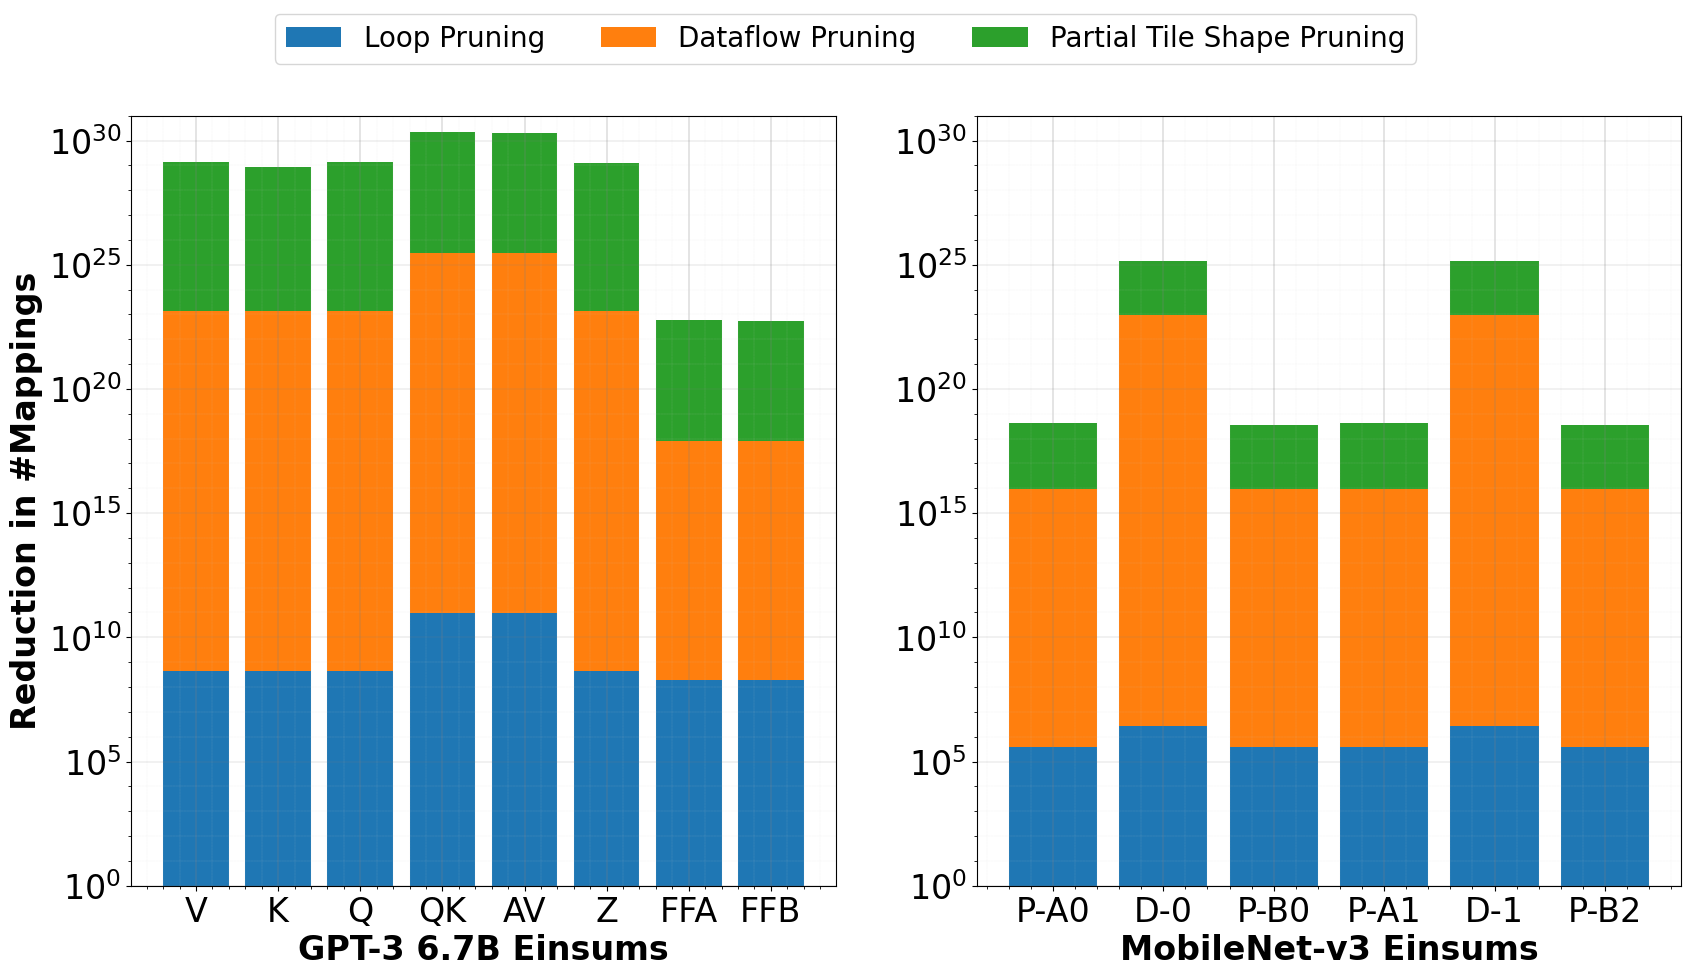

In [3]:
renames = {
    "Piecewise": "P-",
    "Depthwise": "D-"
}
def rename(x):
    if isinstance(x, str):
        for k, v in renames.items():
            x = x.replace(k, v)
        return x
    elif isinstance(x, dict):
        return {rename(k): rename(v) for k, v in x.items()}
    elif isinstance(x, list):
        return [rename(i) for i in x]
    else:
        return x

fig, axs = plt.subplots(figsize=(20, 10), ncols=2)
ax = axs[0]
make_stacked_bar_chart(rename(reductions_gpt), ax)
# ax.set_title(f"TPU-like, GPT-3 6.7B")
ax.set_xlabel("GPT-3 6.7B Einsums")
ax.set_ylabel(f"Reduction in #Mappings")
ax.get_legend().remove()
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")
ax.set_ylim(0, 31)

ax = axs[1]
make_stacked_bar_chart(rename(reductions_mobilenet), ax)
# ax.set_title(f"NVDLA-like, MobileNet-v3")
ax.set_xlabel("MobileNet-v3 Einsums")
ax.set_ylabel(f"Reduction in #Mappings")
ax.get_legend().remove()
ax.set_ylabel("")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")
ax.set_ylim(0, 31)

handles, labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels, loc = 'upper center', ncol=3, labelspacing=0.0, fontsize=20)

plt.savefig("outputs/plots/mapspace_size_reduction.pdf", bbox_inches="tight")
plt.show()

/tmp/ipykernel_6750/658228118.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"$10^{{{int(y)}}}$" for y in ax.get_yticks()])
/tmp/ipykernel_6750/658228118.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha="right")
/tmp/ipykernel_6750/3266322915.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")
/tmp/ipykernel_6750/658228118.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"$10^{{{int(y)}}}$" for y in ax.get_yticks()])
/tmp/ipykernel_6750/658228118.py:18: UserWarning: set_ticklabels() should onl

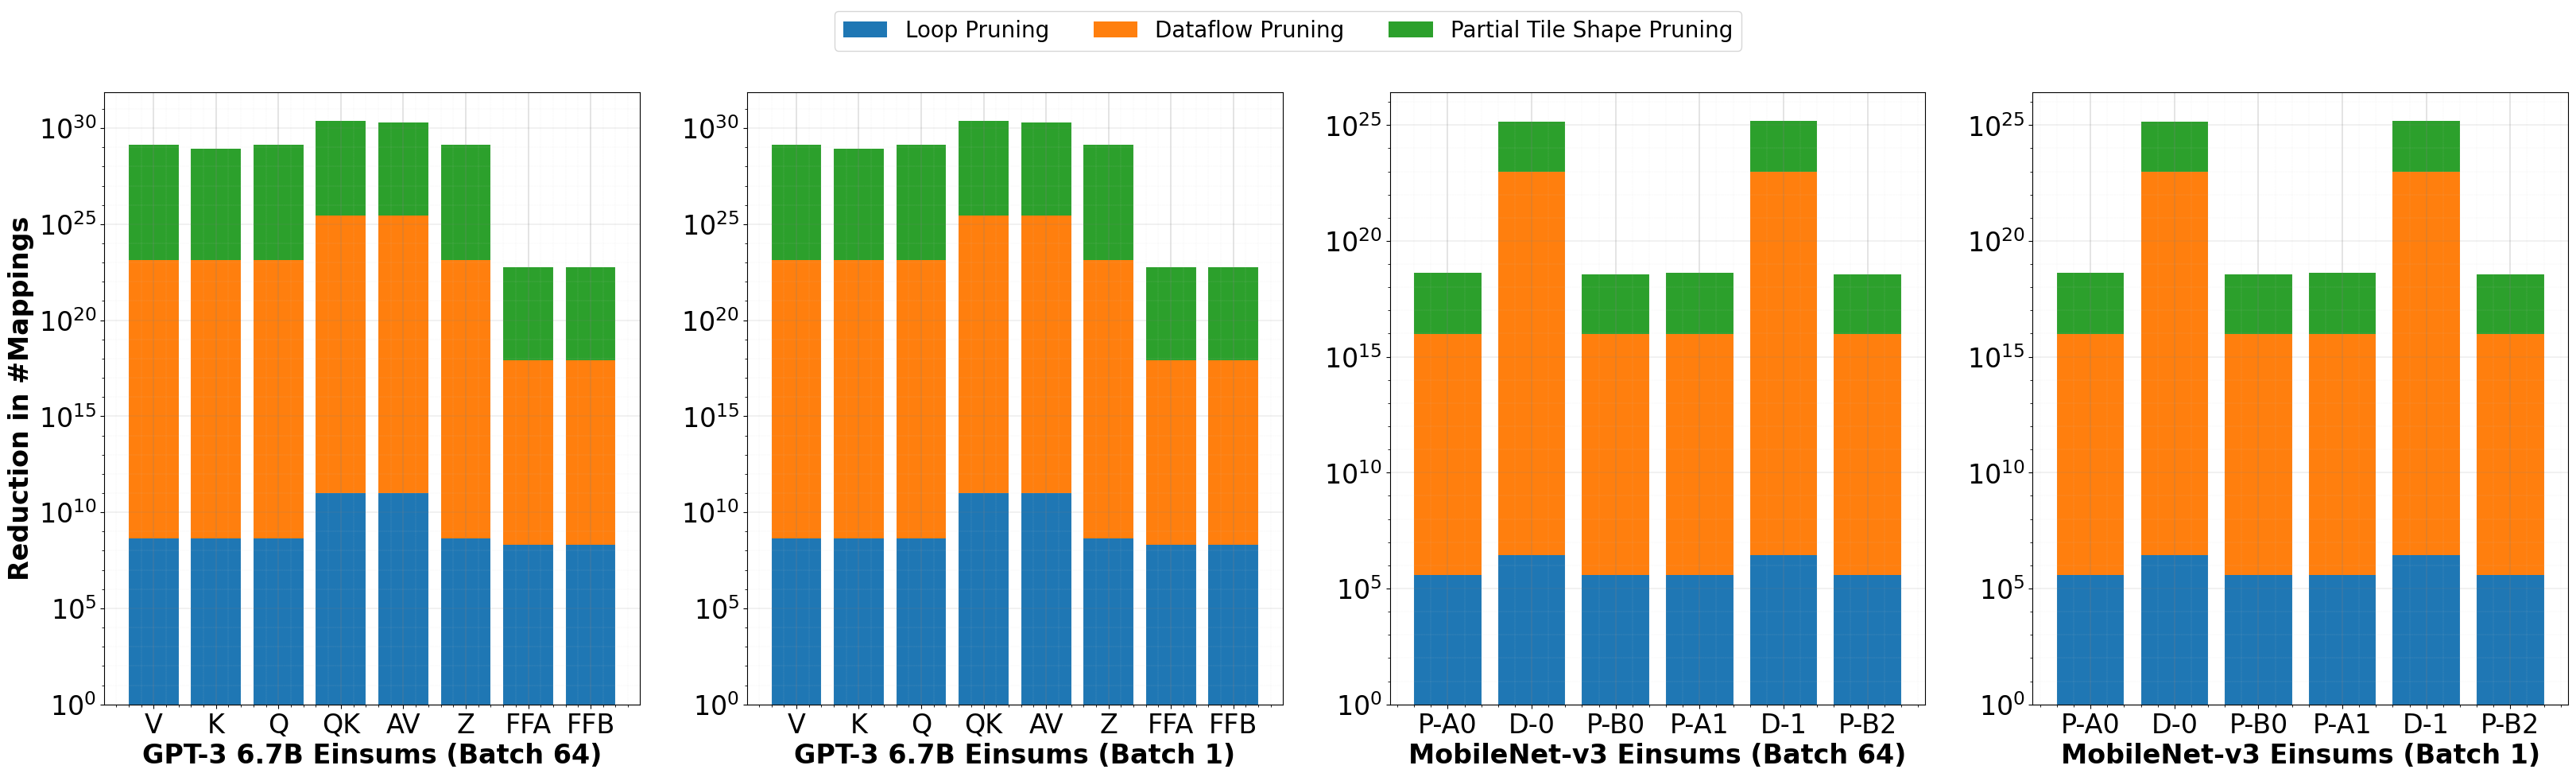

In [4]:
renames = {
    "Piecewise": "P-",
    "Depthwise": "D-"
}
def rename(x):
    if isinstance(x, str):
        for k, v in renames.items():
            x = x.replace(k, v)
        return x
    elif isinstance(x, dict):
        return {rename(k): rename(v) for k, v in x.items()}
    elif isinstance(x, list):
        return [rename(i) for i in x]
    else:
        return x

fig, axs = plt.subplots(figsize=(40, 10), ncols=4)
ax = axs[0]
make_stacked_bar_chart(rename(reductions_gpt), ax)
# ax.set_title(f"TPU-like, GPT-3 6.7B")
ax.set_xlabel("GPT-3 6.7B Einsums (Batch 64)")
ax.set_ylabel(f"Reduction in #Mappings")
ax.get_legend().remove()
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")

ax = axs[1]
make_stacked_bar_chart(rename(reductions_gpt), ax)
# ax.set_title(f"TPU-like, GPT-3 6.7B")
ax.set_xlabel("GPT-3 6.7B Einsums (Batch 1)")
ax.set_ylabel(f"Reduction in #Mappings")
ax.get_legend().remove()
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")
ax.set_ylabel("")

ax = axs[2]
make_stacked_bar_chart(rename(reductions_mobilenet), ax)
# ax.set_title(f"NVDLA-like, MobileNet-v3")
ax.set_xlabel("MobileNet-v3 Einsums (Batch 64)")
ax.set_ylabel(f"Reduction in #Mappings")
ax.get_legend().remove()
ax.set_ylabel("")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")

ax = axs[3]
make_stacked_bar_chart(rename(reductions_mobilenet), ax)
# ax.set_title(f"NVDLA-like, MobileNet-v3")
ax.set_xlabel("MobileNet-v3 Einsums (Batch 1)")
ax.set_ylabel(f"Reduction in #Mappings")
ax.get_legend().remove()
ax.set_ylabel("")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")

handles, labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels, loc = 'upper center', ncol=3, labelspacing=0.0, fontsize=20)

plt.savefig("outputs/plots/mapspace_size_reduction_multibatch.pdf", bbox_inches="tight")
plt.show()


[Text(0, 0, 'D-0'),
 Text(1, 0, 'D-1'),
 Text(2, 0, 'P-A0'),
 Text(3, 0, 'P-B2'),
 Text(4, 0, 'P-A1'),
 Text(5, 0, 'P-B0')]

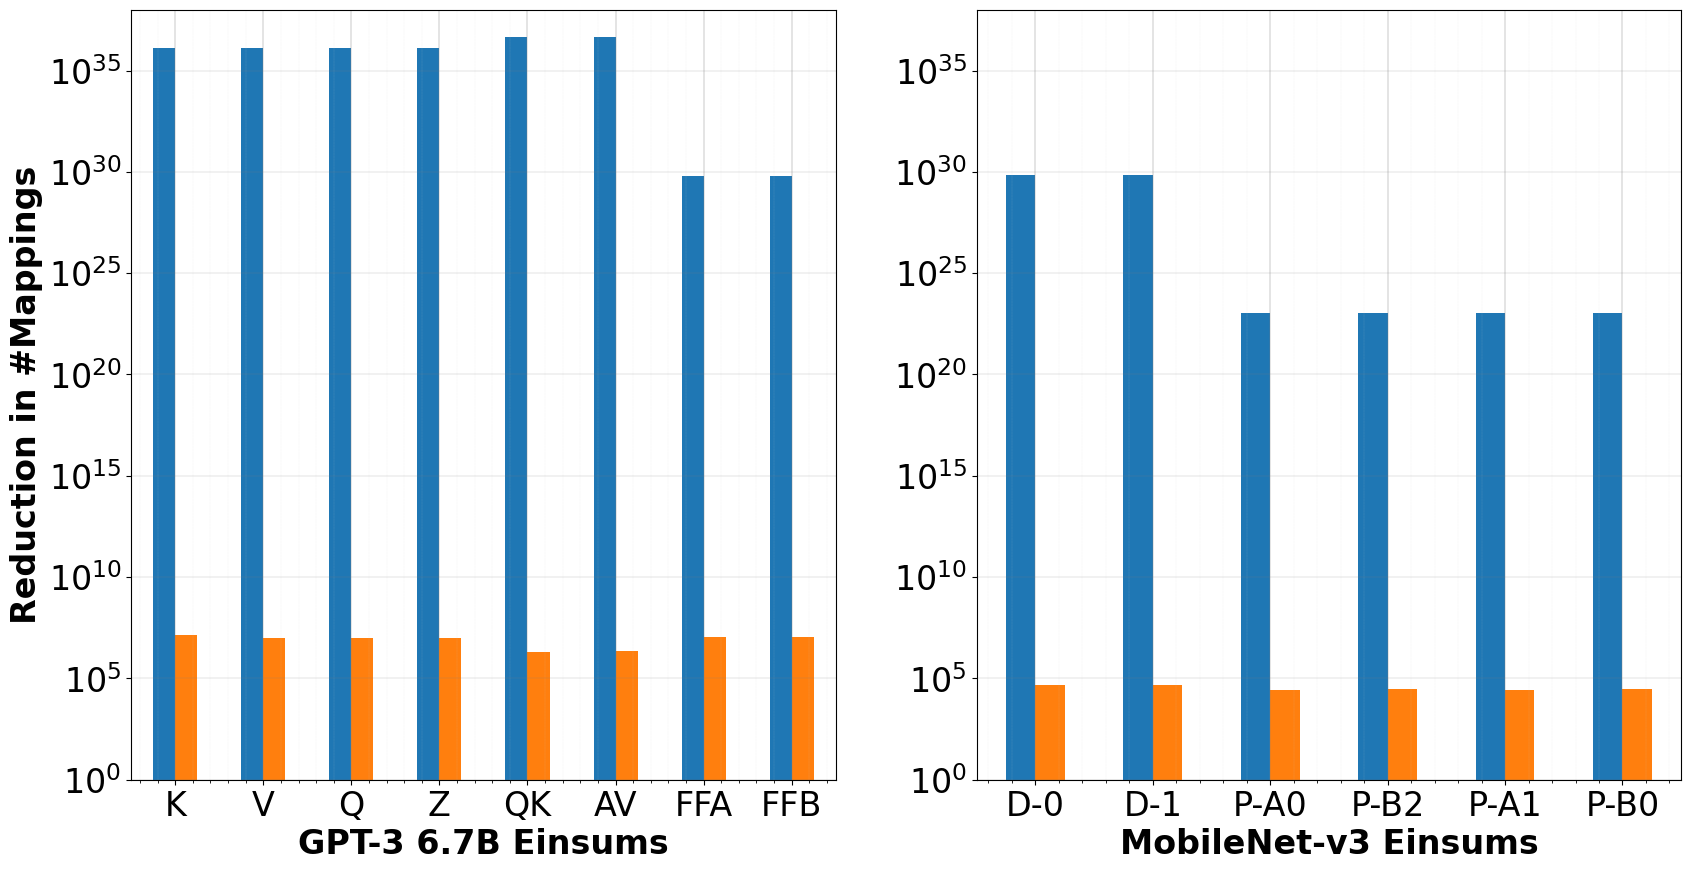

In [5]:
import pandas as pd

def make_side_by_side_bar_chart(
    results: dict[str, dict[str, float]],
    ax: plt.Axes
):
    results_df = pd.DataFrame(results)
    results_df.index = results_df.index.map(rename)
    results_df.columns = results_df.columns.map(rename)
    results_df.plot(kind="bar", ax=ax)
    format_plot(ax)
    # ax.set_ylabel(f"Reduction in #Mappings")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")
    ax.set_yscale("log")
    ax.set_ylim(1, 1e38)
    # ax.set_yticklabels([f"$10^{{{s(y)}}}$" for y in ax.get_yticks()])

    # Make a broken Y axis. I want 1-10^10 for one part. Then 10^20-10^40 for the other part.

fig, axs = plt.subplots(figsize=(20, 10), ncols=2)

ax = axs[0]
make_side_by_side_bar_chart(
    {
        "Total": {k: v for k, v in totals_gpt.items() if k not in ["QK_softmax", "I"]},
        "Evaluated": {k: v for k, v in evaluated_gpt.items() if k not in ["QK_softmax", "I"]},
    },
    ax
)
# ax.set_title(f"TPU-like, GPT-3 6.7B")
ax.set_xlabel("GPT-3 6.7B Einsums")
ax.set_ylabel(f"Reduction in #Mappings")
ax.get_legend().remove()
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")

ax = axs[1]
make_side_by_side_bar_chart(
    {
        "Total": totals_mobilenet,
        "Evaluated": evaluated_mobilenet,
    },
    ax
)
# ax.set_title(f"NVDLA-like, MobileNet-v3")
ax.set_xlabel("MobileNet-v3 Einsums")
# ax.set_ylabel(f"Reduction in #Mappings")
ax.get_legend().remove()
# Remove the y ticks

ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")

In [6]:
import pandas as pd
from math import log10

all_einsums = [
    k for k in list(totals_gpt.keys()) + list(totals_mobilenet.keys())
    if k not in ["QK_softmax", "I"]
]

all_totals = {}
all_evaluated = {}
for k in all_einsums:
    all_totals[k] = float(totals_gpt.get(k, 0) + totals_mobilenet.get(k, 0))
    all_evaluated[k] = float(evaluated_gpt.get(k, 0) + evaluated_mobilenet.get(k, 0))

df = pd.DataFrame({
    "Total": pd.Series(all_totals),
    "Evaluated": pd.Series(all_evaluated),
    "Reduction": pd.Series(all_totals) / pd.Series(all_evaluated),
})
df.index = df.index.map(rename)

def float_format(x):
    if x < 100:
        return int(round(x))
    x_logged = round(log10(x))
    return int(x_logged)

raw = df.to_latex(
    escape=False,
    index=True,
    bold_rows=True,
    column_format="lrrr",
    float_format=float_format,
    na_rep="--",
    longtable=False,
)

# -----------------------
# POST-PROCESSING
# -----------------------

lines = raw.splitlines()

out = []

# 1. Replace header with multicolumn header
for line in lines:
    if line.startswith(r"\toprule"):
        out.append(r"\begin{tabular}{lrrr}")
        out.append(r"& \multicolumn{3}{c}{$\#$ Mappings (Orders of Magnitude)} \\")
        out.append(r"Einsum & Total & Evaluated & Reduction \\")
        out.append(r"\midrule")
        break

# 2. Rows — manually insert section breaks
gpt3_keys = ["V", "K", "Q", "Z", "QK", "AV", "FFA", "FFB"]
mobilenet_keys = ["D-0", "D-1", "P-A0", "P-A1", "P-B0", "P-B2"]

# Emit GPT-3 section
out.append(r"GPT-3 \\")
out.append(r"\midrule")
for k in gpt3_keys:
    row = df.loc[rename(k)]
    out.append(
        fr"\textbf{{{rename(k)}}} & {float_format(row['Total'])} & {float_format(row['Evaluated'])} & {float_format(row['Reduction'])} \\"
    )

# Spacing
out.append(r"\midrule")

# Emit MobileNet section
out.append(r"MobileNet-V3 \\")
out.append(r"\midrule")
for k in mobilenet_keys:
    row = df.loc[rename(k)]
    out.append(
        fr"\textbf{{{rename(k)}}} & {float_format(row['Total'])} & {float_format(row['Evaluated'])} & {float_format(row['Reduction'])} \\"
    )

out.append(r"\bottomrule")
out.append(r"\end{tabular}")

final_latex = "\n".join(out)
print(final_latex)


\begin{tabular}{lrrr}
& \multicolumn{3}{c}{$\#$ Mappings (Orders of Magnitude)} \\
Einsum & Total & Evaluated & Reduction \\
\midrule
GPT-3 \\
\midrule
\textbf{V} & 36 & 7 & 29 \\
\textbf{K} & 36 & 7 & 29 \\
\textbf{Q} & 36 & 7 & 29 \\
\textbf{Z} & 36 & 7 & 29 \\
\textbf{QK} & 37 & 6 & 30 \\
\textbf{AV} & 37 & 6 & 30 \\
\textbf{FFA} & 30 & 7 & 23 \\
\textbf{FFB} & 30 & 7 & 23 \\
\midrule
MobileNet-V3 \\
\midrule
\textbf{D-0} & 30 & 5 & 25 \\
\textbf{D-1} & 30 & 5 & 25 \\
\textbf{P-A0} & 23 & 4 & 19 \\
\textbf{P-A1} & 23 & 4 & 19 \\
\textbf{P-B0} & 23 & 4 & 19 \\
\textbf{P-B2} & 23 & 4 & 19 \\
\bottomrule
\end{tabular}
